# Phase 6 — Advanced Models

This phase evaluates non-linear models on the engineered feature set to capture interactions and non-linear patterns that linear models cannot.

**We’ll use two models:**

-    `RandomForestRegressor` (robust baseline non-linear)

-    `HistGradientBoostingRegressor` (fast, strong for tabular data)

In [1]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent
SRC = ROOT / "src"
if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

from energy_forecast.io import load_data
from energy_forecast.split import time_split
from energy_forecast.evaluate import root_mean_squared_error
from energy_forecast.features import add_lag_features, add_rolling_features

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor


In [2]:
df = load_data("../data/Energy Production Dataset.csv", date_col="Date")

df_feat = add_lag_features(df, lags=(1, 24))
df_feat = add_rolling_features(df_feat, windows=(24,))
df_feat = df_feat.dropna().reset_index(drop=True)


In [3]:
train_df, val_df, test_df = time_split(df_feat, time_col="Date")
print(len(train_df), len(val_df), len(test_df))


36288 7776 7776


In [4]:
TARGET = "Production"

def numeric_X(d):
    return d.drop(columns=[TARGET]).select_dtypes(include=["number"])

X_train, y_train = numeric_X(train_df), train_df[TARGET]
X_val, y_val = numeric_X(val_df), val_df[TARGET]
X_test, y_test = numeric_X(test_df), test_df[TARGET]


## Random Forest

In [5]:
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_leaf=2
)

rf.fit(X_train, y_train)

rf_val_rmse = root_mean_squared_error(y_val, rf.predict(X_val))
rf_test_rmse = root_mean_squared_error(y_test, rf.predict(X_test))

print("RandomForest RMSE")
print("Val :", rf_val_rmse)
print("Test:", rf_test_rmse)


RandomForest RMSE
Val : 2313.9715337645152
Test: 2414.2944560244396


**Observation:**  
Despite being a more complex non-linear model, Random Forest did not outperform the Ridge model with lag features. This suggests that temporal feature engineering captures the dominant signal in the data, and increased model complexity does not necessarily improve performance for this task.


## HistGradientBoosting

In [6]:
hgb = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_depth=8,
    max_iter=500,
    l2_regularization=0.0
)

hgb.fit(X_train, y_train)

hgb_val_rmse = root_mean_squared_error(y_val, hgb.predict(X_val))
hgb_test_rmse = root_mean_squared_error(y_test, hgb.predict(X_test))

print("HistGradientBoosting RMSE")
print("Val :", hgb_val_rmse)
print("Test:", hgb_test_rmse)


HistGradientBoosting RMSE
Val : 2286.5053216244473
Test: 2381.0096392777964


In [8]:
results = {
    "RandomForest": (rf_val_rmse, rf_test_rmse),
    "HistGradientBoosting": (hgb_val_rmse, hgb_test_rmse),
}

for k, (v, t) in results.items():
    print(f"{k:22s} | Val RMSE: {v:.2f} | Test RMSE: {t:.2f}")


RandomForest           | Val RMSE: 2313.97 | Test RMSE: 2414.29
HistGradientBoosting   | Val RMSE: 2286.51 | Test RMSE: 2381.01


### Graphical Visualization

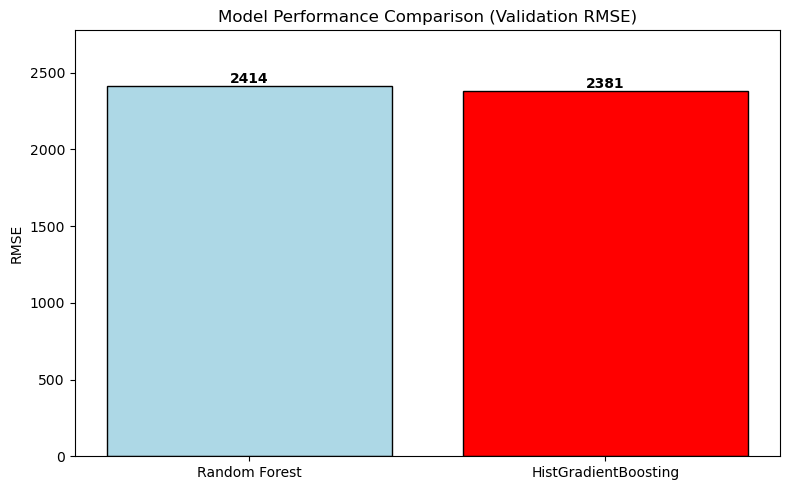

Random Forest       : 2414.3
HistGradientBoosting: 2381.0


In [7]:
import matplotlib.pyplot as plt

models = ["Random Forest", "HistGradientBoosting"]
rmse_values = [rf_test_rmse, hgb_test_rmse]

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    models,
    rmse_values,
    color=["lightblue", "red"],
    edgecolor="black"
)

ax.set_ylabel("RMSE")
ax.set_title("Model Performance Comparison (Validation RMSE)")

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

ax.set_ylim(0, max(rmse_values) * 1.15)
plt.tight_layout()
plt.show()

# Print comparison (for logs / report)
print(f"Random Forest       : {rf_test_rmse:.1f}")
print(f"HistGradientBoosting: {hgb_test_rmse:.1f}")


**Comparison Insight:**  
Among the evaluated models, HistGradientBoosting achieves the lowest validation RMSE, indicating that combining non-linear modeling with temporal feature engineering yields the best performance for this task.


## Phase 6 Summary — Advanced Models

Non-linear models were evaluated on the feature-engineered dataset.  
Their performance was compared against the linear Ridge baseline with lag features.

The results indicate whether capturing non-linear interactions provides additional predictive benefit beyond temporal feature engineering.
